# Attitude determination

## october campaign

### load data from logs

In [2]:
date='2021-18-17'
import os
import pandas as pd
#aug1=pd.read_csv(indir+date+'/hk_data_decoded.txt',delimiter='\t')
oct1=pd.read_csv("/home/limu/Space/logs/alpha/hk_data_october_17.txt",delimiter='\t')
oct1.columns

Index(['RealTimeStamp', 'DK EpochTimeStamp [s]', 'DK TimeStamp', 'CunkID',
       'ChunkType', 'Length [B]', 'LdSt magX [nT]', 'LdSt magY [nT]',
       'LdSt magZ [nT]', 'LdStTot [nT]', 'OBC magX [nT]', 'OBC magY [nT]',
       'OBC magZ [nT]', 'OBCtot [nT]', 'OBC_9DOF_Temp [*C]',
       'OBCgyroX [deg/s]', 'OBCgyroY [deg/s]', 'OBCgyroZ [deg/s]',
       'OBCaccX [mG]', 'OBCaccY [mG]', 'OBCaccZ [mG]', 'SolT X+ [*C]',
       'SolT Y+ [*C]', 'SolT X- [*C]', 'SolT Y- [*C]', 'SolT Z- [*C]',
       'OBC_Temp [*C]', 'ssTemp(X+) [*C]', 'ssTemp(Y+) [*C]',
       'ssTemp(X-) [*C]', 'ssTemp(Y-) [*C]', 'ssTemp(Z-) [*C]', 'ssIRRad(X+)',
       'ssIRRad(Y+)', 'ssIRRad(X-)', 'ssIRRad(Y-)', 'ssIRRad(Z-)',
       'ssAngleX (X+) [deg]', 'ssAngleY (X+) [deg]', 'ssAngleX (Y+) [deg]',
       'ssAngleY (Y+) [deg]', 'ssAngleX (X-) [deg]', 'ssAngleY (X-) [deg]',
       'ssAngleX (Y-) [deg]', 'ssAngleY (Y-) [deg]', 'ssAngleX (Z-) [deg]',
       'ssAngleY (Z-) [deg]', 'ssGyroX (X+) [deg/s]', 'ssGyroY (X+) [deg/s

In [3]:
mok=oct1
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta
mags=np.array([np.array(mok[mok.columns[6+i]]) for i in range(3)]).T
mags=mags[1:-1]
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]
dt=np.array([(t-times[0]).seconds for t in times])


[[<matplotlib.lines.Line2D at 0x7faf8d6ffd60>],

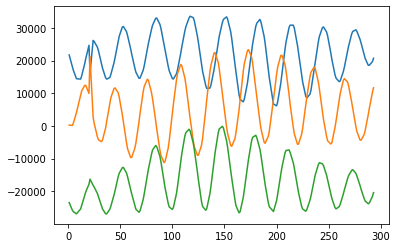

In [4]:
[pl.plot(dt[1:-1],m) for m in mags.T]

#### angles and gyros

set of five 2axis datas from gyro sensors on Lode modules (really? Lode has 3-axis gyro)

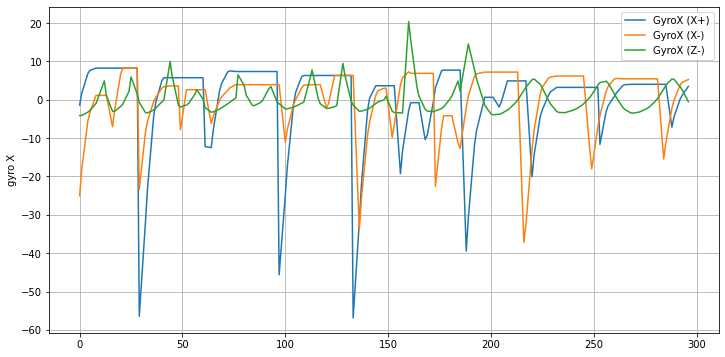

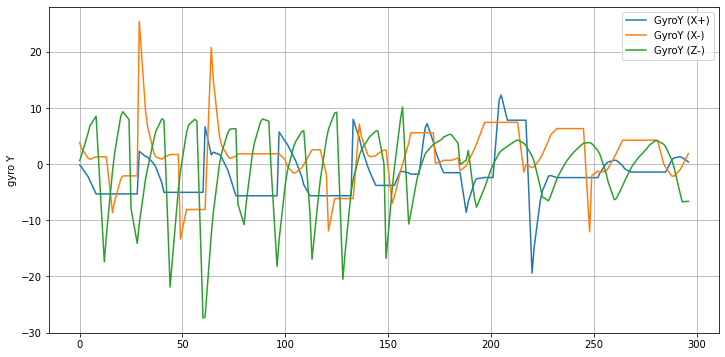

In [5]:
pl.figure(figsize=(12,6))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10::4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.grid()
pl.figure(figsize=(12,6))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9::4]]
pl.legend()
pl.grid()

#### test of correlations via principal component analysis

In [6]:
gall=np.array([mok[c].to_numpy() for c in mok.columns[-10:]])
gall-=np.mean(gall,1)[:,np.newaxis]
gall/=np.std(gall,1)[:,np.newaxis]
gcov=gall@gall.T

In [7]:
eiv,evec=np.linalg.eig(gcov)

[[<matplotlib.lines.Line2D at 0x7faf8b3efcd0>],

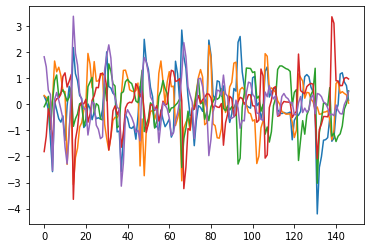

In [8]:
profiles=[v@gall for v in evec[:5]]
[pl.plot(p) for p in profiles]

In [9]:
np.array(np.where(evec>0.5)).T #most correlated pairs?

array([[0, 8],
       [1, 0],
       [2, 0],
       [2, 6],
       [3, 4],
       [4, 2],
       [5, 7],
       [7, 3],
       [8, 6],
       [9, 1]])

1.0000000000000002

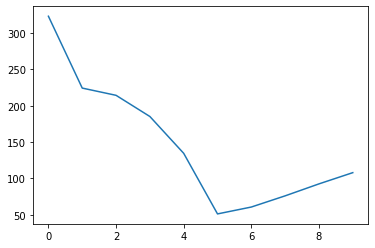

In [10]:
pl.plot(eiv)
(gall[2]**2).mean()

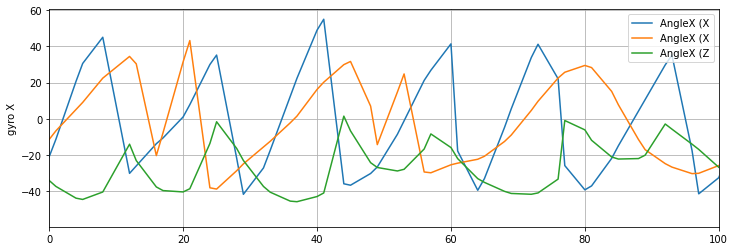

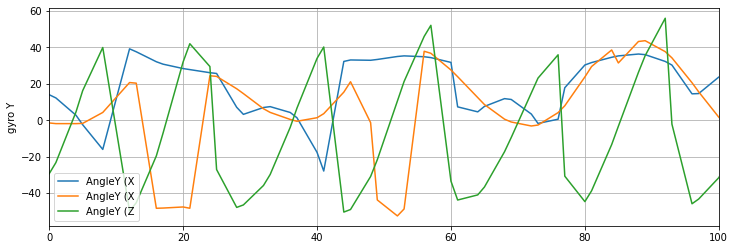

In [11]:
tmax=100
pl.figure(figsize=(12,4))
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-10-10:-10:4]]#[-9::2]
pl.ylabel("gyro X")
pl.legend()
pl.xlim(0,tmax)
pl.grid()
pl.figure(figsize=(12,4))
pl.ylabel("gyro Y")
[pl.plot(dt,mok[c],label=c[2:-8]) for c in mok.columns[-9-10:-10:4]]
pl.legend()
pl.xlim(0,tmax)
pl.grid()

In [12]:
## no 
geero=[i for i,m in enumerate(mok.columns) if m.find('OBCgyro')>=0]
[mok[mok.columns[i+3]].std() for i in geero] #no data here
#pl.plot(dt,mok[mok.columns[geero[2]]]) 

[0.0, 0.0, 0.0]

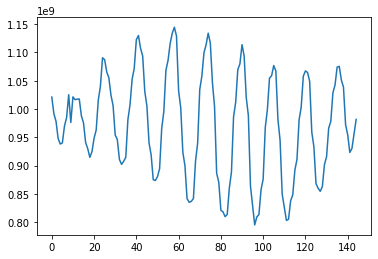

In [13]:
pl.plot((mags**2).sum(1))

Text(0.5, 1.0, 'Solar panel temps')

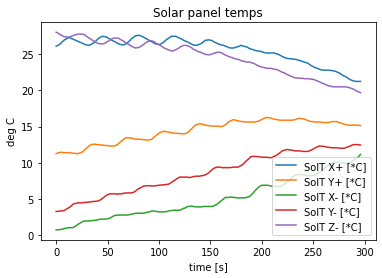

In [14]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(21,26)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(21,26)])
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("Solar panel temps")

Text(0.5, 1.0, 'SunSensor temps')

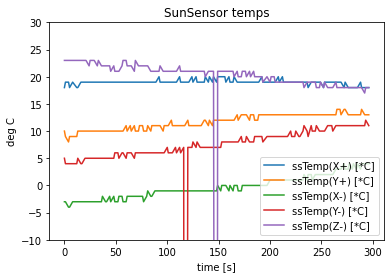

In [15]:
tpanel=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in range(27,32)]])
[pl.plot(dt,t) for t in tpanel]
pl.legend([mok.columns[i] for i in range(27,32)])
pl.ylim(-10,30)
pl.ylabel("deg C")
pl.xlabel("time [s]")
pl.title("SunSensor temps")

In [136]:
irpos=[i for i in range(len(mok.columns)) if mok.columns[i].find("IRR")>0]
rep=[]
qth = (48.7408,-21.2284,380)
from astropy import coordinates as coord
from astropy import units as u
import predict

tle= """GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965"""
#tle= """GRBALPHA
#1 47959U 21022AD  22089.06574127  .00004075  00000-0  27671-3 0  9996
#2 47959  97.5376 350.3030 0022746  59.5456 300.8062 15.06733026 54867"""

pars=['longitude','latitude','altitude','epoch']
kosice=coord.EarthLocation.from_geodetic(qth[1],-qth[0],qth[2])#,unit=(u.degree, u.degree,u.meter))
kosrad=np.sqrt(sum(np.array(kosice.value.tolist())**2))*1e-3 #earth distance in km

d=mok['DK TimeStamp'][0]
x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
y=predict.observe(tle, qth, at=x.timestamp())
print([y['longitude'],y['latitude'],y['altitude']])

tle= """GRBALPHA
1 47959U 21022AD  21261.56473559  .00000999  00000-0  72704-4 0  9998
2 47959  97.5478 161.8339 0022206 358.3728 121.5047 15.05855836 25884"""

tle= """GRBALPHA                
1 47959U 21022AD  21193.19189613  .00000206  00000-0  18448-4 0  9992
2 47959  97.5583  94.8656 0020163 224.9247 288.7034 15.05738947 15594"""

for d in mok['DK TimeStamp']:
    x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
    y=predict.observe(tle, qth, at=x.timestamp())
    rep.append([y['longitude'],y['latitude'],y['altitude']])
print(rep[0])
rep=np.array(rep).T
if rep[0].max()-rep[0].min()>200:rep[0]=(rep[0]+180)%360-180

[294.62560622779716, -62.09383739345331, 557.2180755783047]
[294.1800854774886, -62.709765303466, 559.4631124741627]


In [135]:
rep_recent=rep

In [137]:
rep[:,0],rep[:,-1]

(array([294.18008548, -62.7097653 , 559.46311247]),
 array([264.11866088, -79.1763636 , 563.20497887]))

Text(0, 0.5, 'latitude')

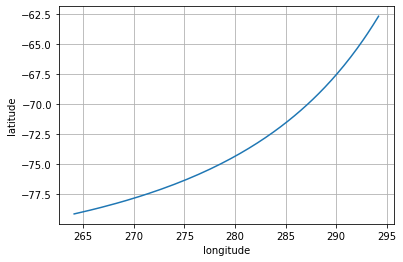

In [138]:
pl.plot(rep[0],rep[1])
pl.grid()
pl.xlabel("longitude")
pl.ylabel("latitude")

#### magnetic field

World Magnetic Model from http://geomag.bgs.ac.uk/data_service/models_compass/wmm_calc.html

In [18]:
from periodogram import get_mag_dir

pomag=[]
for i in [0,len(rep)-1]:
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag.append(get_mag_dir(day,rep[1][i],rep[0][i],rep[2][i]))
    
pom1,pom2=pomag[0],pomag[-1]
vecs=[np.array([dic[t+'-intensity'] for t in ['east','north','vertical']]) for dic in pomag]#'declination'] 
norm=lambda v:np.sqrt(np.dot(v,v))
nvecs=[v/norm(v) for v in vecs]
nvecs

[array([ 0.24458514,  0.22145782, -0.94399923]),
 array([ 0.24654192,  0.21527611, -0.94491972])]

In [143]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in rep.T] 
import periodogram as pg
sunvec_hall=np.array([pg.sun_vec_CHall(t) for t in times])

In [20]:
# calculated magnetic vectors

all_rot=[]
from satutils import triad
dtot=dt[-1]
magdir=[coord.SkyCoord(pomag[i]['inclination'],pomag[i]['declination'],unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir]]
magvec=[m/norm(m) for m in magvec]
mag_inter = lambda t:(t/dtot*magvec[1]+(1-t/dtot)*magvec[0]) #linear interpolation of start/end



In [139]:
pomag_recent=pomag2

In [140]:
pomag2=[]
for i in range(0,len(times),10):
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag2.append(get_mag_dir(day,rep[1][i],rep[0][i],rep[2][i]))


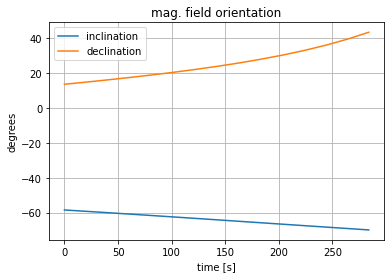

In [150]:
mag_altaz=np.array([[pomag2[i]['inclination'],pomag2[i]['declination']] for i in range(len(pomag2))]).T
pl.plot(dt[::10],mag_altaz[0],label="inclination")
pl.plot(dt[::10],mag_altaz[1],label="declination")
pl.legend()
pl.ylabel("degrees")
pl.xlabel("time [s]")
pl.title("mag. field orientation")
pl.grid()

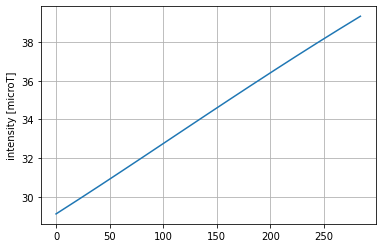

In [156]:
#pl.plot(dt[::10],mag_altaz[1],label="declination")#
i=2
pl.plot(dt[::10],[p['total-intensity']/1e3 for p in pomag2])
pl.ylabel("intensity [microT]")
pl.grid()

In [144]:
s=satcoor2[0]
rep[0][::10]-[s.lon.value for s in satcoor2[::10]]

array([360., 360., 360., 360., 360., 360., 360., 360., 360., 360., 360.,
       360., 360., 360., 360.])

In [161]:
magdir2=[coord.SkyCoord(pomag2[i]['inclination'],pomag2[i]['declination'],unit="deg",frame="altaz",location=satcoor2[10*i],obstime=times[10*i]) for i in range(len(pomag2))]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir2]]
magvec=[m/norm(m) for m in magvec]
mag_inter1 = lambda t:(t/dtot*magvec[-1]+(1-t/dtot)*magvec[0]) #linear interpolation of start/end


In [166]:
dtex=list(dt[::10])+[dt[-1]*2-dt[-2]]
magvec=np.array(magvec+[2*magvec[-1]-magvec[-2]]) #small extrapolation
from scipy import interpolate as ip
intfun=[ip.interp1d(dtex,magvec[:,i]) for i in range(3)]
mag_inter2 = lambda t:np.array([pp(t) for pp in intfun])
mag_inter=mag_inter2

In [24]:
## prediction of Sun direction in body frame?
print("Hall sun vectors [times 1,10,147]")
print(np.array([sunvec_hall[i] for i in [1,10,-1]])) # in ECI
#from astropy.coordinates import get_body_barycentric, get_body, get_sun, EarthLocation
from astropy.time import Time
sunvec_apy=[]  #coord.get_sun(Time(t)) for j,t in enumerate(times)]
#for j,s in enumerate(sunvec_apy):
for j in range(len(times)):
    loc=coord.EarthLocation.from_geodetic(rep[0][j],rep[1][j],rep[2][j]*1e3)
    sunvec_apy.append(coord.get_sun(time=Time(times[j])))
    sunvec_apy[-1].location=loc
    #print(rep[0][j],rep[1][j])
import satutils as su
sunvec_loc=[su.fromangle(s.altaz.az.value,s.altaz.alt.value) for s in sunvec_apy] #local frame
sunvec_eci=[su.fromangle(s.ra.value,s.dec.value) for s in sunvec_apy] #equatorial
np.array([sunvec_eci[i] for i in [1,10,-1]])

Hall sun vectors [times 1,10,147]
[[-0.79041381 -0.56203706 -0.2436398 ]
 [-0.79041138 -0.56203993 -0.24364105]
 [-0.79037797 -0.56207949 -0.2436582 ]]


array([[-0.91553827, -0.36904756, -0.15997989],
       [-0.91553666, -0.36905093, -0.15998135],
       [-0.9155145 , -0.36909721, -0.16000141]])

In [22]:
j=0
coo=coord.AltAz(0*u.deg,-90*u.deg,obstime=times[j], location=satcoor2[j])
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
sco=coord.SkyCoord(coo)#,frame='altaz')
nadir=sco
sco.icrs, rep[:,j],tm.deg,sco.separation(sunvec_apy[j]).deg

(<SkyCoord (ICRS): (ra, dec) in deg
     (173.13377064, 79.80301342)>,
 array([262.56078502, -79.68199158, 561.37571759]),
 353.4716814100295,
 90.24622821071249)

In [23]:
sco.separation(sunvec_apy[j]).deg

90.24622821071249

In [25]:
mbody=np.array([m/norm(m) for m in mags])

coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
tm.deg

353.4716814100295

#### correcting mag sensor normalization

assuming the total mag intensity should not vary (periodically) 

we try to minimize variability (std. deviation)

In [26]:
mcop=[0.99,1.02]
weis=lambda p:[p[0],p[1],3-p[1]-p[0]]
from scipy import optimize as op
goflat=op.fmin(lambda p:np.std(((mags*weis(p))**2).sum(1)),mcop)
goflat

Optimization terminated successfully.
         Current function value: 30122426.650988
         Iterations: 44
         Function evaluations: 86


array([0.89187898, 1.06213353])

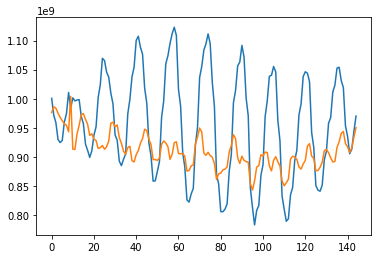

In [27]:
pl.plot(((mags*weis(mcop))**2).sum(1))

pl.plot(((mags*weis(goflat))**2).sum(1))


In [28]:
mbody=mags*weis(goflat)
mbody=np.array([m/norm(m) for m in mbody])
#mbody=mbody/norm(mbody)[:,np.newaxis]

### finding proper sun direction

- fix the magnetic field direction
- est. angle between sun and magnet
- vary "azimuth" of sun vector to fit best the observation

In [174]:
#angle2_recent=angle2.copy()

In [175]:
dt2=np.array(dt[1:-1])# skip first/last point

angle=[np.arccos(np.dot(mag_inter(dt[i]),sunvec_hall[i])) for i in range(1,len(dt)-1)]
#pl.plot(np.rad2deg(angle))
angle2=np.array([np.arccos(np.dot(mag_inter(dt[i]),sunvec_eci[i])) for i in range(1,len(dt)-1)])
#YES, we do use (correct?) mag field interpolation
#angle=np.mean(angle) #changes negligeable
print(np.rad2deg(np.max(angle2)-np.min(angle2)))
print(np.rad2deg((np.max(angle2)+np.min(angle2))/2))
#angle2=np.mean(angle2)
#np.rad2deg(angle),np.rad2deg(angle2)

40.28744287402853
106.32342103956621


Text(0, 0.5, 'angle Sun-North [deg]')

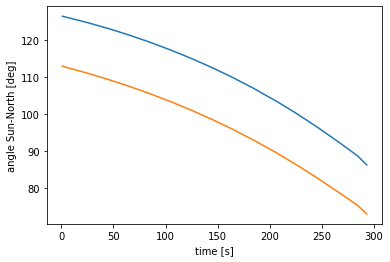

In [179]:
pl.plot(dt2,np.rad2deg(angle2))
pl.plot(dt2,np.rad2deg(angle))
pl.xlabel("time [s]")
#pl.plot(dt2,np.rad2deg(angle2_recent))
pl.ylabel("angle Sun-North [deg]")

angle2 - between Sun and magnet. North  
wee - vector (set of..) with angle2 from `[1,0,0]` 

    rmatx@mbody -> [1,0,0]
    rmatx.T@[1,0,0] -> mbody
    
    rmatx.T@wee -> body frame

In [31]:
phi=np.r_[:2*np.pi:40j]
j,k=3,20
wee=np.array([np.cos(angle2[j]),np.sin(angle2[j])*np.cos(phi[k]),np.sin(angle2[j])*np.sin(phi[k])])

rmatx=triad(mbody[j],[0,0,1])
np.arccos((rmatx.T@wee).dot(mbody[j])),angle2[j]

(1.4418107759368408, 1.4418107759368408)

In [32]:
#[norm(a) for a in awee.T]
rmatx=triad(mbody[j],[0,0,1])
np.arccos((rmatx.T@wee).dot(mbody[j])),angle2[j]

(1.4418107759368408, 1.4418107759368408)

calculate Sun direction in body (satellite) coordinate frame (for all possible rotations perpendicular to magnetic field):

Text(0.5, 0, 'rotation (roll) angle')

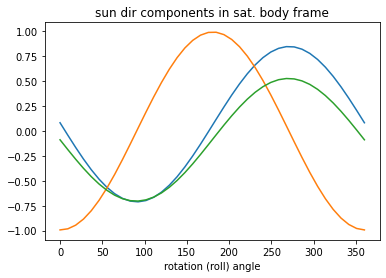

In [33]:
#np.allclose(rmatx.T@rmatx,np.eye(3)) # rmatx is orthonormal
j=0
rmatx=triad(mbody[j],[0,0,1])
#awee=np.array([np.cos(angle2[j])*np.ones_like(phi),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#
awee=np.array([np.cos(angle2[j])*np.ones_like(phi),np.sin(angle2[j])*np.cos(phi),np.sin(angle2[j])*np.sin(phi)])#
asun=rmatx.T@awee# in body frame
        #triad(mbody[j],[0,1,0]).T@awee[j] for  
[pl.plot(np.rad2deg(phi),s) for s in asun]
pl.title("sun dir components in sat. body frame")
pl.xlabel("rotation (roll) angle")

In [34]:
np.std([a.dot(mbody[j]) for a in asun.T])

4.2886630747702835e-17

#### similar for Earth (as light source) 

**not finished !!**

In [35]:
#[a for a in nadir.fk5.cartesian]
nadir_eci=su.eloc2cart(nadir.fk5.cartesian)
i=0
np.rad2deg(np.arccos(np.dot(mag_inter(dt[i]),nadir_eci))),np.rad2deg(np.arccos(np.dot(sunvec_eci[i],nadir_eci)))

(137.83193465747752, 90.24898556489393)

### try some model

we don't have much details about the sensor from [NEEDRONIX](https://sunsensor.eu/NXSS3v00.html)

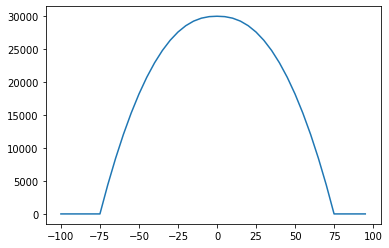

In [36]:
from scipy import stats as st
sens_amp=3e4
mang=75
zex=2.3
viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*sens_amp
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

#### simulate SunSensor signal for different roll angle

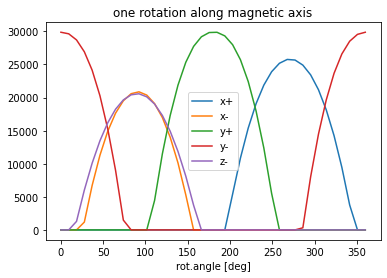

In [39]:
def predict_roll(asun):
    xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
    yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
    zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
    return xp,yp,xm,ym,zm
xp,yp,xm,ym,zm=predict_roll(asun)
pl.plot(np.rad2deg(phi),xp,np.rad2deg(phi),xm)
pl.plot(np.rad2deg(phi),yp,np.rad2deg(phi),ym)
pl.plot(np.rad2deg(phi),zm)
pl.xlabel("rot.angle [deg]")
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

In [40]:
tle_all=open("/home/limu/Code/Notebook/Astro/alpha/ephem/tle_all.txt").readlines()
tle_arr=[tle_all[4*i+1].replace('-','.').replace('+','.').split()[3:]+tle_all[4*i+2].replace('-','.').split()[2:] for i in range(len(tle_all)//4)]

### statistics of other HK data

we correct amplitudes following "typical range" (saved in `coramp.pkz`) based on histograms

In [41]:
import pickle
irnorm=pickle.load(open("coramp.pkz","rb"))
irnorm

array([[13460.6, 23544.6],
       [10851.5, 23139.5],
       [16331.5, 29408.6],
       [11708. , 20586. ],
       [10867.8, 22073.8]])

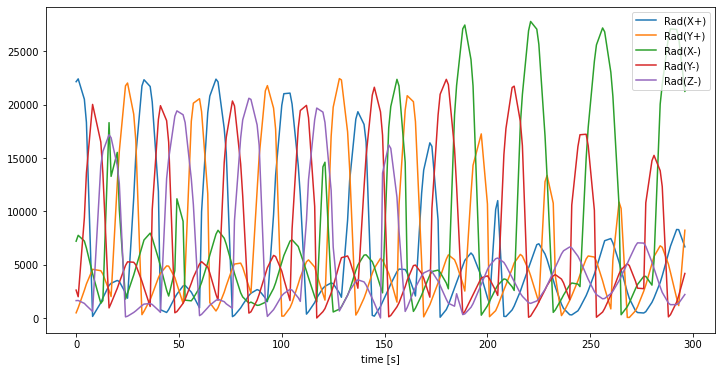

In [44]:
fig=pl.figure(figsize=(12,6))
irsens=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in irpos]])
pl.xlabel("time [s]")
[pl.plot(dt,s) for s in irsens]
pl.legend([mok.columns[i][4:] for i in irpos])
pl.savefig("/home/limu/Space/logs/alpha/sunsens_october.png")

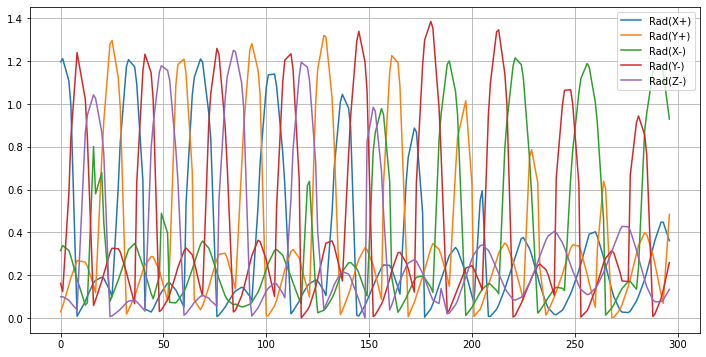

In [45]:
irsens2=irsens*2/(irnorm[:,0]+irnorm[:,1])[:,np.newaxis]
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.legend([mok.columns[i][4:] for i in irpos])
pl.grid()

(64, 147)

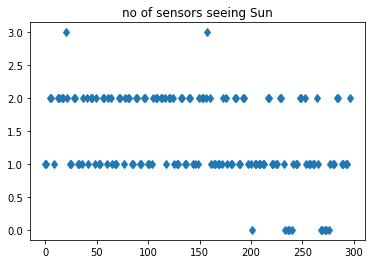

In [46]:
pl.plot(dt,(np.array(irsens2)>0.45).sum(0),'d')
pl.title("no of sensors seeing Sun")
sum((np.array(irsens2)>0.45).sum(0)>1),len(irsens[0])

[[<matplotlib.lines.Line2D at 0x7faf818c2050>],

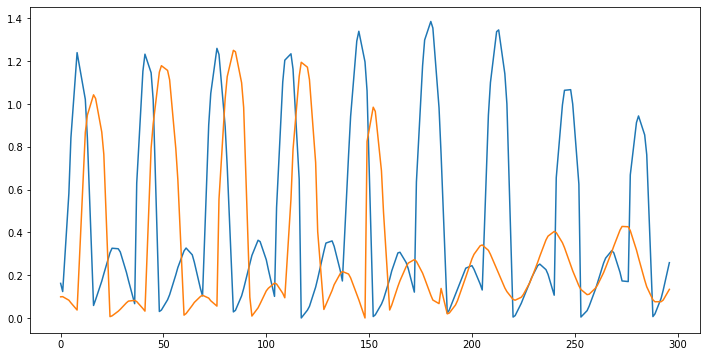

In [47]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2[-2:]]

(0.0, 120.0)

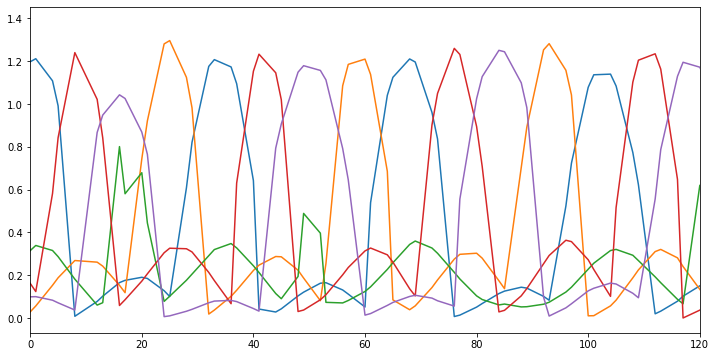

In [48]:
fig=pl.figure(figsize=(12,6))
[pl.plot(dt,s) for s in irsens2]
pl.xlim(0,120)

### rotating model vs. reality

Text(0, 0.5, 'simulated')

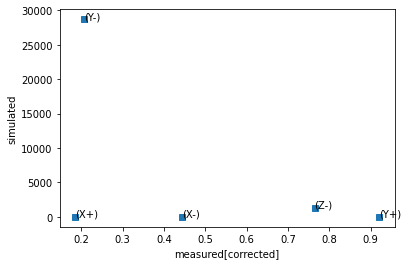

In [49]:
labels=[mok.columns[i][7:] for i in irpos]
simu=np.array([xp,yp,xm,ym,zm])
k=10
pl.plot(irsens2[:,k],simu[:,2],'s')
for i in range(5):
    pl.text(irsens2[i,k],simu[i,2],labels[i])
np.corrcoef(irsens2[:,k],simu[:,2])[0][1]
pl.xlabel("measured[corrected]")
pl.ylabel("simulated")
#pl.plot(phi,xp,phi,xm)
#pl.plot(phi,yp,phi,ym)
#pl.plot(phi,zm)

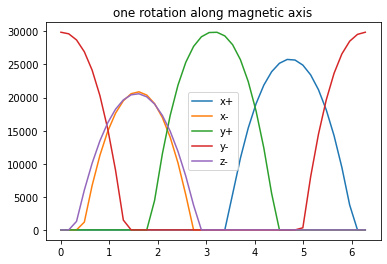

In [50]:
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

#### matrix of rotation for every time

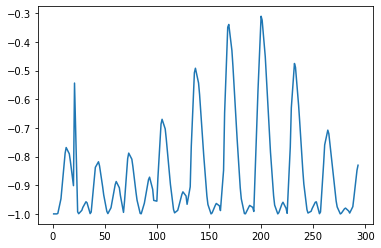

In [180]:
aliad=[triad(m,[0,0,1]) for m in mbody]
pl.plot(dt2,[a[1][1] for a in aliad])

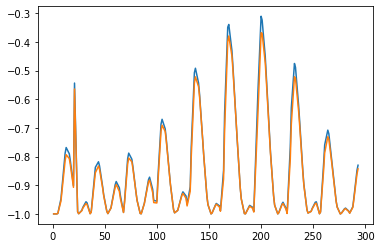

In [181]:
#should consider possible misalignment: small shift of mbody or "z axis" vector
dphi,dtheta=0.05,0.05
zaxis=[np.cos(dphi)*np.sin(dtheta),np.sin(dphi)*np.sin(dtheta),np.cos(dtheta)]
#zaxis
aliad2=[triad(m,zaxis) for m in mbody]
pl.plot(dt2,[a[1][1] for a in aliad])
pl.plot(dt2,[a[1][1] for a in aliad2])

Text(0, 0.5, 'roll angle[deg]')

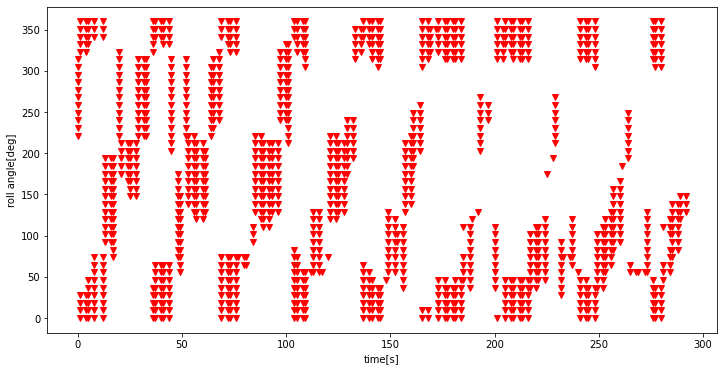

In [183]:
correl1=lambda real,simu:np.corrcoef(real,simu)[0][1] if simu.std()>10 else 0
correl2=lambda real,simu:st.spearmanr(real,simu).correlation #only rank(order) matters (Spearman)
correl=correl1

irsens22=irsens2[:,1:-1]

pl.figure(figsize=(12,6))
dphi=np.rad2deg(phi)
rmatx=triad(mbody[3],[0,0,1])
good_angs=[]
match_stats=[]
for i in range(len(dt2)):
    awee=np.array([np.cos(angle2[i])*np.ones_like(phi),np.sin(angle2[i])*np.cos(phi),np.sin(angle2[i])*np.sin(phi)])# sun dir in EQ frame
    #rmatx=triad(mbody[i],[0,0,1])
    try:
        asun=aliad[i].T@awee # in body frame
        simu=np.array(predict_roll(asun))
    except:
        print(f"failed {i}")
        good_angs.append([])
        continue
    prof1=[correl(irsens22[:,i],s) if s.std()>100 else 0 for s in simu.T]
    prof1=np.array(prof1)
    match_stats.append(np.percentile(prof1,[0,10,90,100]))
    pind=np.where(prof1>=0.97*prof1.max())[0]
    pl.plot(dt[i]*np.ones_like(pind),dphi[pind],'rv')
    good_angs.append(dphi[pind])
pl.xlabel("time[s]")
pl.ylabel("roll angle[deg]")

In [185]:
good_angs[0].mean(),phi0

(267.6923076923077, 267.0435877167787)

In [186]:
phi0=good_angs[0].mean()
timsel=np.array([dt[i] for i in range(len(good_angs)) if np.any((np.r_[good_angs[i]]>200)*(np.r_[good_angs[i]]<210))])
ind_pass=np.where(timsel[1:]-timsel[:-1]>20)[0]+1
tpass=timsel[ind_pass]
period=(tpass[1:]-tpass[:-1]).mean()
phi0,period

(267.6923076923077, 44.75)

In [188]:

imax=sum(dt2<180)
def phi_fun(period,phi0,samp,sphase=90,accel=0):
    '''predict phase with some sinusoidal modulation (samp, sphase) and period gradient (accel)
    '''
    phi_max=phi0+360*(dt2/period+dt2**2*accel)
    phi_max-=360*(phi_max/360).astype(int)
    return phi_max+samp*np.sin(np.deg2rad(phi_max-sphase))

correl=correl1
#correl=lambda real,simu:st.spearmanr(real,simu).correlation 
def model(period,phi0,samp,sphase,accel,predict=None):
    if predict==None: predict=predict_roll
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=aliad[i].T@awee # in body frame
        simu=np.array(predict_roll(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)
period=35 #by eye
pini=[period,phi0,3.5,160,0]
imax,model(*pini)

(88, 57.07193478896821)

In [189]:
from scipy.optimize import fmin
#before
#pfin=[ 3.34101036e+01,  2.67043588e+02,  3.55348684e+00,  1.59004931e+02,  -4.34752357e-06]
pfin1=fmin(lambda p:model(*p),pini)
#period,phi0,samp,sphase,accel=pfin
pfin1

array([3.46070521e+01, 2.72281566e+02, 3.65898255e+00, 1.52199999e+02,
       1.16192623e-06])

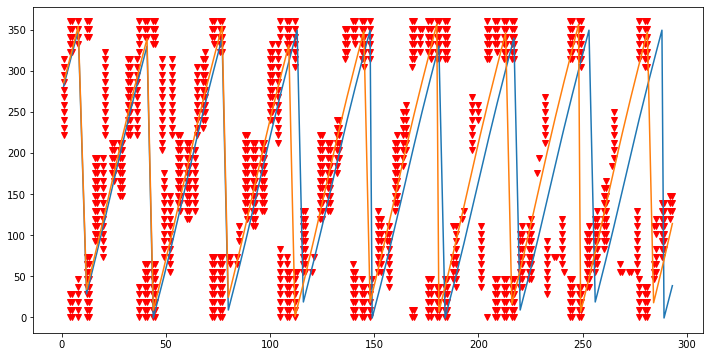

In [190]:
pl.figure(figsize=(12,6))
for i in range(len(dt2)):
    pgood=good_angs[i]
    pl.plot(dt2[i]*np.ones_like(pgood),pgood,'rv')
#pl.plot(dt,phi_max,':')
period,phi0,samp,sphase,accel=pini
phi_pred=phi_fun(period,phi0,samp,sphase,accel)
period,phi0,samp,sphase,accel=pfin1
pl.plot(dt2,phi_pred)
pl.plot(dt2,phi_fun(*pfin1))

In [65]:
#change of period over observ. time (acceleation/decceleration)
pfin1[-1]*dt2[-1]

-0.0012738244054145724

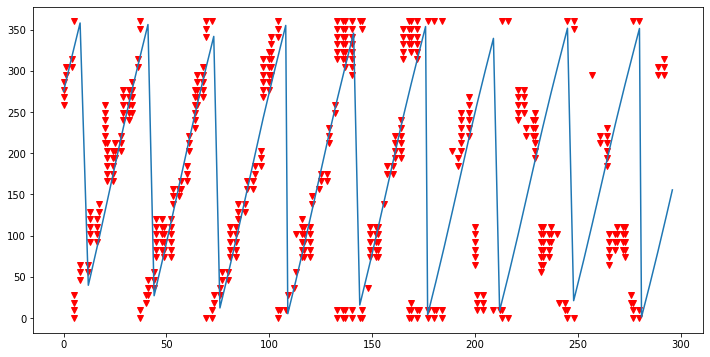

In [360]:
#pfin=[34.17824531, 287.31454935,  29.40824437,  91.28652249,0]
pl.figure(figsize=(12,6))
for i in range(len(dt2)):
    pgood=good_angs[i]
    pl.plot(dt[i]*np.ones_like(pgood),pgood,'rv')
#pl.plot(dt,phi_max,':')
pl.plot(dt,phi_fun(*pfin2))

In [191]:
def simu_sun(phi,rmatx):
    rphi=np.deg2rad(phi)
    awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
    return np.array(predict_roll(rmatx.T@awee))

### how good is overall correlation of model vs. measured sunsensors?

earth albedo contribution is not simulated, so values below 40% of max are neglected in first approx.

In [192]:
wsel=slice(None,imax)
bangs=phi_fun(*pfin1)[wsel]
simu_all=np.array([simu_sun(p,aliad[i]) for i,p in enumerate(bangs)]).T

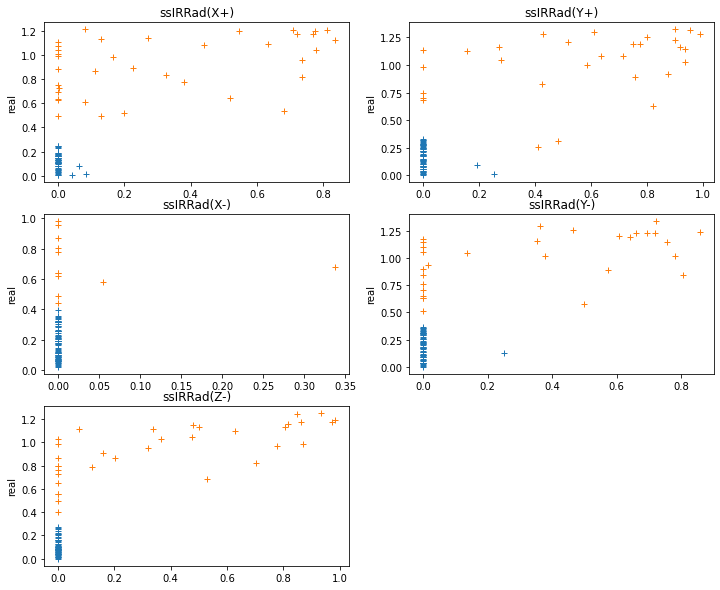

In [193]:
pl.figure(figsize=(12,10))
inlim=0.4
for i in range(5):
    pl.subplot(3,2,i+1)
    bad=((simu_all[i]/sens_amp)<inlim)*(irsens2[i,wsel]<inlim)
    nx,ny=simu_all[i][bad]/sens_amp,irsens2[i,wsel][bad]
    pl.plot(nx,ny,'+')
    nx,ny=simu_all[i][bad==False]/sens_amp,irsens2[i,wsel][bad==False]
    pl.plot(nx,ny,'+')
    pl.title(mok.columns[irpos[i]])
    pl.ylabel('real')

In [196]:
pfin_start=pfin1.copy()

wsel=slice(None,130)
def minfun(pfin,inlim=0.2,axes=[],debug=0):
    merit=[]
    bangs=phi_fun(*pfin)[wsel]
    simu_all=np.array([simu_sun(p,aliad[i]) for i,p in enumerate(bangs)]).T
    cldness=[]
    if len(axes)==0:
        axes=range(len(pfin))
    for i in axes:
        bad=((simu_all[i]/sens_amp)<inlim)*(irsens2[i,wsel]<inlim)
        nx,ny=simu_all[i][bad==False]/sens_amp,irsens2[i,wsel][bad==False]
        if debug==1:
            print(sum(bad),len(nx),nx.std(),)
            continue
        moo=np.polyfit(nx,ny,1)
        #print(len(nx),sum(bad),moo[0])
        ydist=abs(moo[0]*nx+moo[1]-ny)
        ylim=np.percentile(ydist,90)
        ysel=ydist<ylim
        nx,ny=nx[ysel],ny[ysel]
        goodsum=sum((moo[0]*nx+moo[1]-ny)**2*ny)
        badsum=0 #by default, points in bottom left quadrant have low contribution
        merit.append(goodsum+badsum)
        cldness.append(np.std(nx/ny))
    #print(cldness)
    return sum(merit)
minfun(pfin_start,0.2,[0,1,3,4],debug=1)

70 60
49 81
47 83
70 60


0

In [73]:
pfin_start=pfin1.copy()

/tmp/ipykernel_379945/4083701392.py:19: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))
/usr/local/lib64/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


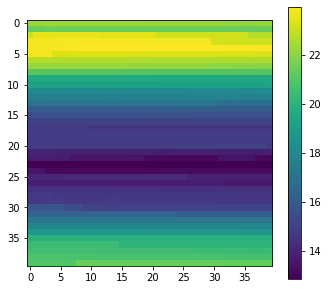

In [75]:
## calculating in a grid 40x40
pfin=pfin_start
bslice1=slice(.8,1.2,40j)
bslice2=slice(.8,1.2,40j)
bslice=bslice1
#pairs=(np.mgrid[bslice,bslice]*pfin[:2,np.newaxis,np.newaxis]).reshape(2,int(bslice.step.imag)**2).T
pairs=(np.mgrid[bslice,bslice2]).reshape(2,int(bslice.step.imag)**2).T
zall=[]
for p in pairs:
    zall.append(minfun([pfin[0],pfin[1]*p[0],pfin[2]*p[1],pfin[3],pfin[4]]))

blen=int(bslice.step.imag)
pl.figure(figsize=(5.5,5))
pl.imshow(np.array(zall).reshape(blen,blen))
pl.colorbar()

In [79]:
pmin=np.argmin(zall)
vmin=[bslice.start+(pmin//blen)/blen/5.,bslice2.start+(pmin%blen)/blen/5.]
zall[pmin],pairs[pmin]
print("minimum:",np.min(zall),pmin)
pfinb=pfin*([1]+list(pairs[pmin])+[1,1])
minfun(pfinb)


12.839877523090323 920


12.839877523090323

In [80]:
def relgrad(qmin,dd=0.1,ilow=0,ihig=-1):
    #looking for gradient in all directions 
    rep=[]
    if ihig==-1: ihig=len(qmin)
    for qi in range(ilow,ihig):
        smin=lambda q:minfun(qmin*([1]*(qi)+[q]+[1]*(len(qmin)-qi-1)))
        rep.append([smin(1-dd),smin(1),smin(1+dd)])

    return rep
relgrad(pfinb,0.3,2)

[[12.880760080599726, 12.839877523090323, 12.854041639587368],
 [13.11787245387901, 12.839877523090323, 13.12213601181962],
 [12.298946583814239, 12.839877523090323, 16.780162114893173]]

In [85]:
qi=4
smin=lambda q:minfun(pfinb*([1]*(qi)+[q]+[1]*(4-qi)))
home=op.fmin(smin,[0.7])
pfinc=pfinb*([1]*(qi)+[home]+[1]*(4-qi))

relgrad(pfinc,0.2)

/tmp/ipykernel_379945/4196927425.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smin=lambda q:minfun(pfinb*([1]*(qi)+[q]+[1]*(4-qi)))


Optimization terminated successfully.
         Current function value: 11.643734
         Iterations: 15
         Function evaluations: 30


/tmp/ipykernel_379945/4196927425.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pfinc=pfinb*([1]*(qi)+[home]+[1]*(4-qi))
/tmp/ipykernel_379945/2897399402.py:21: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))


[[20.21347166980879, 11.643733791245474, 21.08597491744321],
 [23.61663641675154, 11.643733791245474, 20.623654007412085],
 [12.133780316921985, 11.643733791245474, 11.7074796988908],
 [11.908806641864924, 11.643733791245474, 12.29414705726492],
 [11.938798862490286, 11.643733791245474, 12.547440570209565]]

In [87]:
#with longer timespan
qi=3
smin=lambda q:minfun(pfinc*([1]*(qi)+[q]+[1]*(4-qi)))
home=op.fmin(smin,[1.0])
pfind=pfinc*([1]*(qi)+[home]+[1]*(4-qi))

relgrad(pfind)

/tmp/ipykernel_379945/1301754086.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smin=lambda q:minfun(pfinc*([1]*(qi)+[q]+[1]*(4-qi)))


Optimization terminated successfully.
         Current function value: 11.606468
         Iterations: 16
         Function evaluations: 32


/tmp/ipykernel_379945/1301754086.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pfind=pfinc*([1]*(qi)+[home]+[1]*(4-qi))
/tmp/ipykernel_379945/2897399402.py:21: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))


[[18.857970143130803, 11.60646831632601, 19.937203608497928],
 [13.944225843934024, 11.60646831632601, 18.515087600596555],
 [12.099699060314073, 11.60646831632601, 12.060142183493328],
 [11.774670366871497, 11.60646831632601, 12.322696157760669],
 [12.380737227351906, 11.60646831632601, 12.852399557159757]]

In [88]:
pfin_final=np.r_[ 3.35127428e+01,  2.48299696e+02,  3.47652399e+00,  2.06496957e+02,-1.64583810e-06]
pfind-pfin_final

array([-0.10263919980550185, 28.330071788663048, -0.6337345215917263,
       array([-39.72811369]), array([-1.83504655e-06])], dtype=object)

In [92]:
#with longer timespan
qi=2
pfinc=pfin_final
smin=lambda q:minfun(pfinc*([1]*(qi)+[q]+[1]*(4-qi)))
home=op.fmin(smin,[1.0])
pfind=pfinc*([1]*(qi)+[home[0]]+[1]*(4-qi))

relgrad(pfind)

/tmp/ipykernel_379945/958368346.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smin=lambda q:minfun(pfinc*([1]*(qi)+[q]+[1]*(4-qi)))


Optimization terminated successfully.
         Current function value: 9.126725
         Iterations: 20
         Function evaluations: 40


/tmp/ipykernel_379945/958368346.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pfind=pfinc*([1]*(qi)+[home]+[1]*(4-qi))
/tmp/ipykernel_379945/2897399402.py:21: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))


[[19.647482350832483, 9.126724730965378, 17.84589772712728],
 [17.82452872991522, 9.126724730965378, 12.192638738612883],
 [9.205738163404938, 9.126724730965378, 9.410178039764093],
 [9.31039274125119, 9.126724730965378, 9.13617822050123],
 [9.171803118515687, 9.126724730965378, 9.487041306404839]]

In [99]:
minfun(pfind),pfind

/tmp/ipykernel_379945/2897399402.py:21: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))


(14.920576577096888,
 array([ 3.35127428e+01,  2.48299696e+02,  6.28354551e+00,  2.06496957e+02,
        -1.64583810e-06]))

#### add more parameters

In [95]:
global gzex,gmang
gmang=75
gzex=2.3
gsens_amp=sens_amp
viewang=lambda ang:(abs(ang)<gmang)*(1-(abs(ang)/gmang)**gzex)*gsens_amp

def predict_roll(asun):
    xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
    yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
    zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
    return xp,yp,xm,ym,zm

def simu_sun(phi,rmatx):
    rphi=np.deg2rad(phi)
    awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
    return np.array(predict_roll(rmatx.T@awee))

/tmp/ipykernel_379945/2897399402.py:21: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))


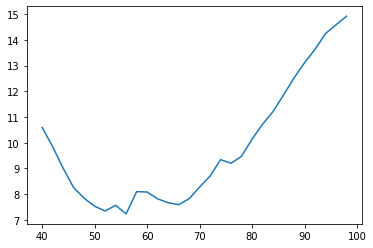

In [96]:
rep=[]
for g in range(40,100,2):
    gmang=g
    rep.append(minfun(pfind))
pl.plot(range(40,100,2),rep)

In [461]:
#pfind=list(pfind[:3])+list(np.concatenate(pfind[3:]))

In [100]:
pfinx=pfind
def exfun(wpars): #only updating sunsensor profile
    global gmang,gzex
    gmang,gzex=wpars[:2]
    return minfun(pfinx)
def exfun2(wpars):  #fitting all parameters
    global gmang,gzex
    gmang,gzex=wpars[-2:]
    return minfun(wpars[:5])
op.fmin(exfun,[52,2.3])

Optimization terminated successfully.
         Current function value: 7.143692
         Iterations: 49
         Function evaluations: 101


array([51.55190683,  2.36375896])

In [470]:
pini3=np.array(list(pfind)+[gmang,gzex])
#op.fmin(exfun,[52,2.3])
#op.fmin(exfun2,pini3)
def relgrad2(qmin,dd=0.1,ilow=0,ihig=-1,nefun=None): #gradient of some arbitrary function (nefun)
    if exfun==None: nefun=minfun
    rep=[]
    if ihig==-1: ihig=len(qmin)
    for qi in range(ilow,ihig):
        smin=lambda q:nefun(qmin*([1]*(qi)+[q]+[1]*(len(qmin)-qi-1)))
        rep.append([smin(1-dd),smin(1),smin(1+dd)])

    return rep
relgrad2(pini3,dd=0.2,nefun=exfun2)

[[19.03698018802741, 5.889558798503989, 20.649023664505336],
 [23.382311583284185, 5.889558798503989, 20.33789086657333],
 [6.089353932373006, 5.889558798503989, 5.840717001593026],
 [6.061158916416398, 5.889558798503989, 6.120105189094735],
 [6.311984647310482, 5.889558798503989, 6.437639503100997],
 [9.112671916889363, 5.889558798503989, 7.772624710456363],
 [6.176887319763489, 5.889558798503989, 5.7862767932541495]]

In [469]:
qi=6
qmin=pini3
smin=lambda q:exfun2(qmin*([1]*(qi)+[q]+[1]*(len(qmin)-qi-1)))
home=op.fmin(smin,[1.0])
home

/tmp/ipykernel_34800/2231368922.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smin=lambda q:exfun2(qmin*([1]*(qi)+[q]+[1]*(len(qmin)-qi-1)))


Optimization terminated successfully.
         Current function value: 5.833131
         Iterations: 12
         Function evaluations: 24


array([0.92792969])

In [519]:
gmang,gzex

(51.196062867357135, 4.976493306000002)

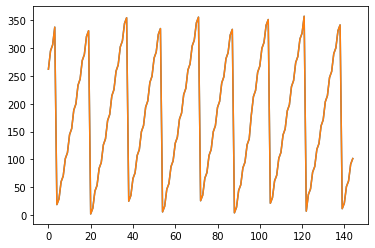

In [448]:
gmang,gzex=mang,zex
pl.plot(model2(*pfinx,75,2.3,rep=1))
gmang,gzex=[50.65334842,  4.1031158 ]
pl.plot(model2(*pfinx,gmang,gzex,rep=1))

In [396]:
pmin=np.argmin(zall)
vmin=[bslice.start+(pmin//blen)/blen/5.,bslice2.start+(pmin%blen)/blen/5.]
zall[pmin],pairs[pmin]

(4.636572001319952, array([0.92307692, 0.83076923]))

In [433]:
pfin_start,pfind

(array([ 3.34060455e+01,  2.82880195e+02,  2.93081426e+01,  8.55176229e+01,
        -3.89686426e-06]),
 array([33.52792234694343, 249.36580809149564, 2.6272508379247745,
        array([214.39377514]), array([-1.66424627e-06])], dtype=object))

In [70]:
#vmin=pairs[pmin]
pfin1=np.array([pfin[0],pfin[1]*vmin[0],pfin[2]*vmin[1],pfin[3],pfin[4]])
minfun(pfin1)

3.8851623674464326

In [430]:
op.fmin(minfun,pfind)

/tmp/ipykernel_34800/3717731204.py:19: RuntimeWarning: divide by zero encountered in true_divide
  cldness.append(np.std(nx/ny))
/usr/local/lib64/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimization terminated successfully.
         Current function value: 7.850470
         Iterations: 316
         Function evaluations: 573


array([ 3.35127428e+01,  2.48299696e+02,  3.47652399e+00,  2.06496957e+02,
       -1.64583810e-06])

### modifying parameters of viewangle function

In [378]:
#imax=len(dt)
imax=88
#pfin2=fmin(lambda p:model(*p),pfin)
pfin2

amp=3e5
def model2(period,phi0,samp,sphase,accel,mang=75,zex=2.3,rep=0):
    viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*sens_amp
    def predict_roll2(asun):
        xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
        yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
        zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
        return xp,yp,xm,ym,zm
    #return model(period,phi0,samp,sphase,accel,predict_roll2)
    phi_pred=phi_fun(period,phi0,samp,sphase,accel)
    if rep==1: return phi_pred
    coefs=[]
    for i in range(imax):
        rphi=np.deg2rad(phi_pred[i])
        awee=np.array([np.cos(angle2[i])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])# sun dir in EQ frame
        asun=aliad[i].T@awee # in body frame
        simu=np.array(predict_roll2(asun))
        coefs.append(1-correl(irsens2[:,i],simu))

    return sum(coefs)

pini2=list(pfin2)+[75,2.3]
#model2(*pini2)
pfin3=fmin(lambda p:model2(*p),pini2)

Optimization terminated successfully.
         Current function value: 36.334479
         Iterations: 55
         Function evaluations: 202


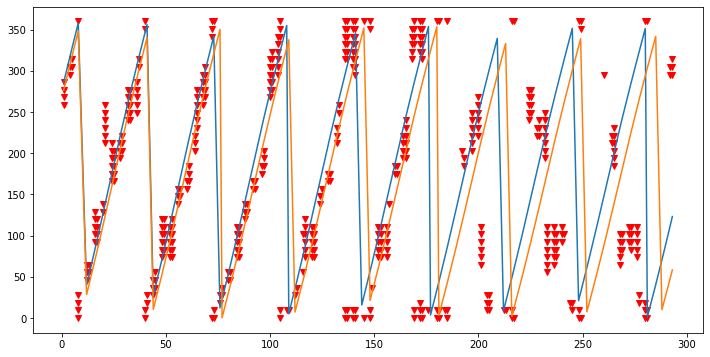

In [432]:
def plot_match(profs):
    pl.figure(figsize=(12,6))
    for i in range(len(dt2)):
        pgood=good_angs[i]
        if len(pgood)>0:
            pl.plot(dt2[i]*np.ones_like(pgood),pgood,'rv')
        #pl.axvline(dt[i],0,0.5)
    #pl.plot(dt,phi_max,':')
    for p in profs:
        pl.plot(dt2,p)#phi_fun(*p))
plot_match([model2(*pini2,rep=1),model2(*pfin3,rep=1)])

In [518]:
pfin3b=fmin(lambda p:model2(*p),pfin3)

Optimization terminated successfully.
         Current function value: 36.216869
         Iterations: 44
         Function evaluations: 200


In [326]:
phi_mod=model2(*pfin3,rep=1)
zerids=np.where(phi_mod[1:]<phi_mod[:-1])[0]
i0,i1=zerids[:2]+1
rphi=np.deg2rad(phi_mod[i0:i1])
awee=np.array([np.cos(angle2[i0:i1])*np.ones_like(rphi),np.sin(angle2[i])*np.cos(rphi),np.sin(angle2[i])*np.sin(rphi)])
asun=rmatx.T@awee

current best fit:

- period 34.4654876
- phase 287.607043
- ampl 11.0766707
- phase2 125.009294
- period drift/accel 1.44935576e-06
       
$$ampl (1-\left(\frac{|ang|}{ang_{lim}}\right)^{zex})$$

- limit angle 73.0307897 deg, 
- power 0.224261374 (!)

In [532]:
i=10
vsel=phi_fun(*pfind)[i]
#sun1=simu_sun(vsel,aliad[i])  
#sun1
wsel=slice(None,110)
bangs=phi_fun(*pfind)[wsel]
simu_all=np.array([simu_sun(p,aliad[i]) for i,p in enumerate(bangs)]).T

sel_real=((np.array(irsens2)>0.45).sum(0)>1)[wsel]
sel_simu=(simu_all>0.45).sum(0)>1

In [534]:
sum(sel_real),sum(sel_simu),sum(sel_real*sel_simu)

(55, 17, 12)

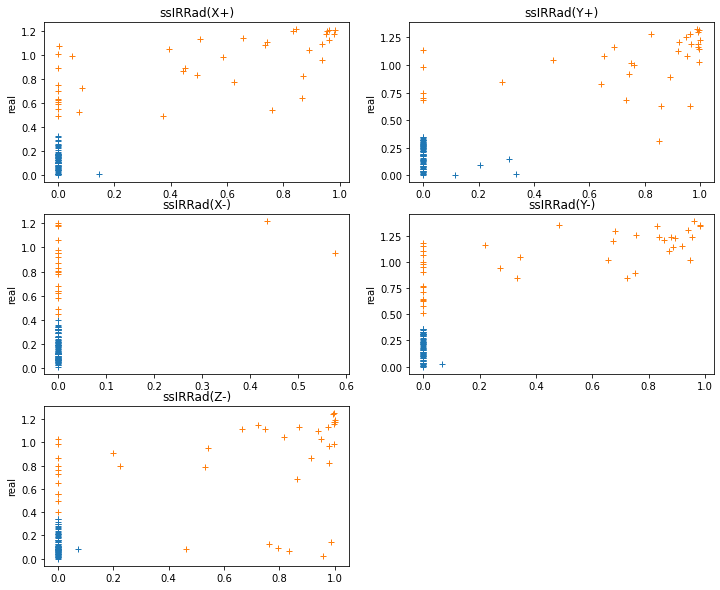

In [520]:

pl.figure(figsize=(12,10))
inlim=0.4
for i in range(5):
    pl.subplot(3,2,i+1)
    bad=((simu_all[i]/sens_amp)<inlim)*(irsens2[i,wsel]<inlim)
    nx,ny=simu_all[i][bad]/sens_amp,irsens2[i,wsel][bad]
    pl.plot(nx,ny,'+')
    nx,ny=simu_all[i][bad==False]/sens_amp,irsens2[i,wsel][bad==False]
    pl.plot(nx,ny,'+')
    pl.title(mok.columns[irpos[i]])
    pl.ylabel('real')

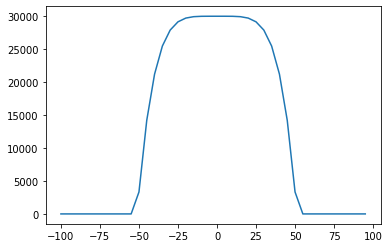

In [513]:
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

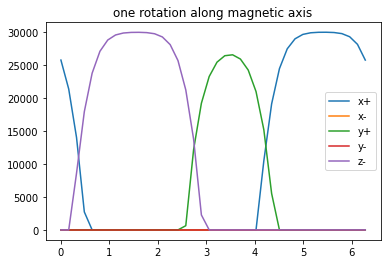

In [514]:
xp,yp,xm,ym,zm=predict_roll(asun)
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

#### calculating correct orientation for one time 
(when two detectors seen Sun)

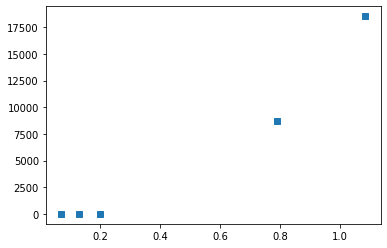

In [541]:
sel_both=np.where(sel_real*sel_simu)[0]
i=sel_both[3]
#time dt2[i]
pl.plot(irsens2[:,i],simu_all[:,i],'s')

In [546]:
mbody[i]
mag_inter(dt2[i])

array([ 0.08257321, -0.5766889 , -0.68818455])

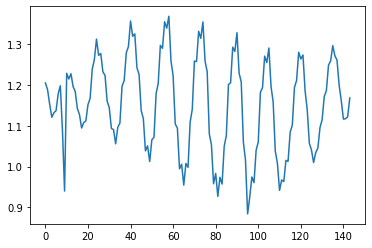

In [90]:
cangs2=(mags[1:,:]*mags[:-1,:]).sum(1)/pomag[0]['total-intensity']**2
pl.plot(cangs2)
#cangs2[cangs2>1]=1
#pl.plot(dt[1:-2][10:40],np.rad2deg(np.arccos(cangs2[10:40])),'-+')

In [312]:
pfin2/pfin-1

array([-0.01562223,  0.00735046,  0.11214999, -0.03911544,  0.05665794])

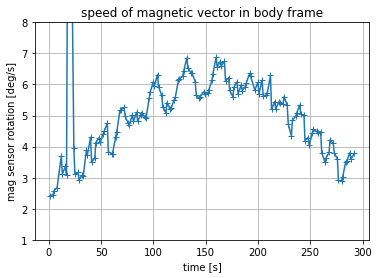

In [279]:
cangs=(mbody[1:,:]*mbody[:-1,:]).sum(1)
pl.plot(dt[1:-2],np.rad2deg(np.arccos(cangs))/ddt,'-+')
pl.xlabel("time [s]")
pl.ylim(1,8)
pl.grid()
pl.ylabel("mag sensor rotation [deg/s]")
pl.title("speed of magnetic vector in body frame")
mbad=np.where(np.rad2deg(np.arccos(cangs))/ddt>10)[0]+1

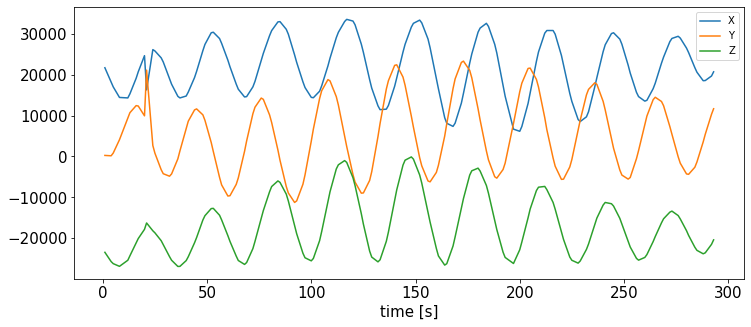

In [482]:
pl.figure(figsize=(12,5))
for m in mags.T:
    pl.plot(dt2,m)
pl.legend(list("XYZ"))
ax=pl.gca()
#ax.get_xlabel().set_fontsize(60)
pl.xlabel("time [s]",fontsize=15)
pl.xticks(fontsize=15);
pl.yticks(fontsize=15);

In [478]:
xx=ax.get_xaxis()
xx.set_ticks?

Signature: xx.set_ticks(ticks, labels=None, *, minor=False, **kwargs)
Docstring:
Set this Axis' tick locations and optionally labels.

If necessary, the view limits of the Axis are expanded so that all
given ticks are visible.

Parameters
----------
ticks : list of floats
    List of tick locations.
labels : list of str, optional
    List of tick labels. If not set, the labels show the data value.
minor : bool, default: False
    If ``False``, set the major ticks; if ``True``, the minor ticks.
**kwargs
    `.Text` properties for the labels. These take effect only if you
    pass *labels*. In other cases, please use `~.Axes.tick_params`.

Notes
-----
The mandatory expansion of the view limits is an intentional design
choice to prevent the surprise of a non-visible tick. If you need
other limits, you should set the limits explicitly after setting the
ticks.
File:      /usr/local/lib64/python3.10/site-packages/matplotlib/axis.py
Type:      method
